#What is Transfer Learning?
Transfer learning is a machine learning technique where a model trained on one task is re-purposed on a second related task.





### Here we will use 10% of the food101 dataset to classify the data and campare the Performance between ResNet and EfficientNet model Using TENSORFLOW

#1:  10% DATA

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_hub as hub

## Get the data

In [2]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-07-15 16:19:27--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 142.250.107.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   188MB/s    in 0.9s    

2022-07-15 16:19:28 (188 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [4]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (256,256)
BATCH_SIZE = 64

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


In [5]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [6]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [7]:
def create_model( model_url, class_number):
    '''
    Take a Model url and Class number and return a Model

    Args:
        Model_url = a tensorflow hub model url
        class_number : number of the output class
    
    Returns:
        An uncompiled model from url

    '''
    feature_extraction_layer = hub.KerasLayer( model_url ,
                                              trainable = False,
                                              name = 'feature_extraction_layer',
                                              input_shape = IMAGE_SHAPE +(3,))
    
    model = keras.Sequential([
                              feature_extraction_layer,
                              keras.layers.Dense( class_number, activation= 'softmax', name = 'output_layer')
    ])
    return model

In [8]:

resnet_model = create_model(resnet_url, class_number = 10)


In [9]:
# Create model
resnet_model = create_model(resnet_url, class_number=train_data_10_percent.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [10]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20220715-161940
Epoch 1/5
12/12 [==============================] - 35s 2s/step - loss: 2.3473 - accuracy: 0.1933 - val_loss: 1.6425 - val_accuracy: 0.4584
Epoch 2/5
12/12 [==============================] - 21s 2s/step - loss: 1.3482 - accuracy: 0.5840 - val_loss: 1.0894 - val_accuracy: 0.6888
Epoch 3/5
12/12 [==============================] - 18s 2s/step - loss: 0.8843 - accuracy: 0.7573 - val_loss: 0.8483 - val_accuracy: 0.7544
Epoch 4/5
12/12 [==============================] - 17s 2s/step - loss: 0.6669 - accuracy: 0.8173 - val_loss: 0.7388 - val_accuracy: 0.7808
Epoch 5/5
12/12 [==============================] - 17s 2s/step - loss: 0.5462 - accuracy: 0.8507 - val_loss: 0.6872 - val_accuracy: 0.7920


In [11]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

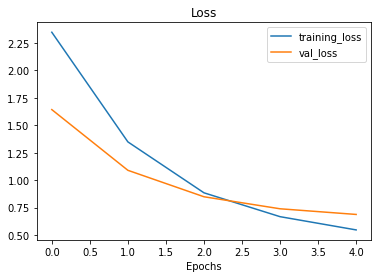

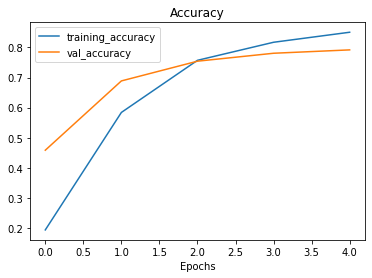

In [12]:
plot_loss_curves(resnet_history)

In [13]:
# Resnet summary 
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


## Effiecientnet model

In [14]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  class_number=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20220715-162144
Epoch 1/5
12/12 [==============================] - 29s 2s/step - loss: 2.0488 - accuracy: 0.2853 - val_loss: 1.6219 - val_accuracy: 0.6364
Epoch 2/5
12/12 [==============================] - 16s 1s/step - loss: 1.4022 - accuracy: 0.7027 - val_loss: 1.1651 - val_accuracy: 0.7752
Epoch 3/5
12/12 [==============================] - 17s 1s/step - loss: 1.0346 - accuracy: 0.7987 - val_loss: 0.9086 - val_accuracy: 0.8180
Epoch 4/5
12/12 [==============================] - 19s 2s/step - loss: 0.8212 - accuracy: 0.8373 - val_loss: 0.7632 - val_accuracy: 0.8408
Epoch 5/5
12/12 [==============================] - 24s 2s/step - loss: 0.6909 - accuracy: 0.8560 - val_loss: 0.6776 - val_accuracy: 0.8548


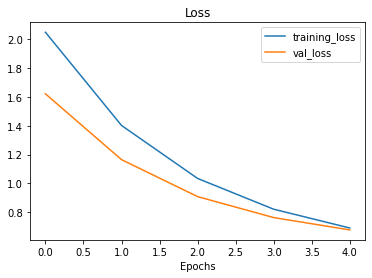

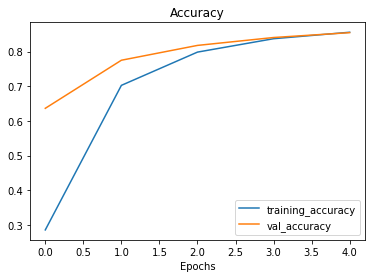

In [15]:
plot_loss_curves(efficientnet_history)

In [16]:
efficientnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [17]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=3LvNO3duomM8akBDRJac985VpjEHko&prompt=consent&access_type=off

In [18]:
# Check out experiments
!tensorboard dev list

https://tensorboard.dev/experiment/rQBeQzcEQY2sQwDMq1ujiw/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction models architectures using 10% of training images
	Id                   rQBeQzcEQY2sQwDMq1ujiw
	Created              2022-07-15 16:30:14 (18 seconds ago)
	Updated              2022-07-15 16:30:16 (16 seconds ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5921132
Total: 1 experiment(s)


In [19]:
# Delete an experiment
# !tensorboard dev delete --experiment_id 7PpfPkyURrqzXwmye5PG7g

# 2: 100% DATA

In [20]:
# Getting the Data
! wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

import zipfile

# Unzip the downloaded file
zip_ref2 = zipfile.ZipFile("10_food_classes_all_data.zip", "r")
zip_ref2.extractall()
zip_ref2.close()

--2022-07-15 16:30:35--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.128, 74.125.197.128, 74.125.135.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   141MB/s    in 3.5s    

2022-07-15 16:30:39 (141 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [23]:
from numpy.core.fromnumeric import reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# setting train and test path
train_path_full = '10_food_classes_all_data/train/'
valid_path_full = '10_food_classes_all_data/test/'

# instanciate the ImageDataGenerator


train_datagen_full = ImageDataGenerator(rescale=1/255.) 


valid_datagen_full = ImageDataGenerator( rescale = 1./255)


# Create the Dataset

shuffle_nob = True


train_data_full = train_datagen_full.flow_from_directory(train_path_full,
                                               target_size = (512,512),
                                               shuffle = shuffle_nob,
                                               class_mode = 'categorical', 
                                               batch_size = 64
                                               )

valid_data_full = valid_datagen_full.flow_from_directory(valid_path_full,
                                               target_size = (512,512),
                                               class_mode = 'categorical', 
                                               batch_size = 64
                                               )


Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


### ResNet

In [25]:
# create resnet model
resnet2_model = create_model(resnet_url, 10)

# compile it
resnet2_model.compile(loss = keras.losses.CategoricalCrossentropy(), 
                  optimizer= keras.optimizers.Adam(),
                  metrics = ['accuracy'])

# fit it

resnet2_history = resnet2_model.fit(train_data_full, epochs = 5, steps_per_epoch  = len(train_data_full), validation_data = valid_data, 
                        validation_steps = len(valid_data_full),
                        callbacks = [create_tensorboard_callback('tensorflow_hub','resnet2_full')])

Saving TensorBoard log files to: tensorflow_hub/resnet2_full/20220715-163137
Epoch 1/5
118/118 [==============================] - 134s 1s/step - loss: 1.0910 - accuracy: 0.6913 - val_loss: 0.5528 - val_accuracy: 0.8576
Epoch 2/5
118/118 [==============================] - 127s 1s/step - loss: 0.5608 - accuracy: 0.8405 - val_loss: 0.4314 - val_accuracy: 0.8764
Epoch 3/5
118/118 [==============================] - 128s 1s/step - loss: 0.4508 - accuracy: 0.8691 - val_loss: 0.3667 - val_accuracy: 0.8912
Epoch 4/5
118/118 [==============================] - 128s 1s/step - loss: 0.3922 - accuracy: 0.8839 - val_loss: 0.3293 - val_accuracy: 0.9024
Epoch 5/5
118/118 [==============================] - 128s 1s/step - loss: 0.3546 - accuracy: 0.8959 - val_loss: 0.3113 - val_accuracy: 0.9084


### EfficientNet

In [26]:
# create resnet model
efficientnet2_model = create_model(efficientnet_url, 10)

# compile it
efficientnet2_model.compile(loss = keras.losses.CategoricalCrossentropy(), 
                  optimizer= keras.optimizers.Adam(),
                  metrics = ['accuracy'])

# fit it

efficientnet2_history = efficientnet2_model.fit(train_data_full, epochs = 5, steps_per_epoch  = len(train_data_full), validation_data = valid_data, 
                        validation_steps = len(valid_data_full),
                        callbacks = [create_tensorboard_callback('tensorflow_hub','efficientnet2_full')])

Saving TensorBoard log files to: tensorflow_hub/efficientnet2_full/20220715-164237
Epoch 1/5
118/118 [==============================] - 104s 790ms/step - loss: 1.1125 - accuracy: 0.7137 - val_loss: 0.5825 - val_accuracy: 0.8772
Epoch 2/5
118/118 [==============================] - 91s 766ms/step - loss: 0.5809 - accuracy: 0.8479 - val_loss: 0.4261 - val_accuracy: 0.8988
Epoch 3/5
118/118 [==============================] - 91s 768ms/step - loss: 0.4735 - accuracy: 0.8691 - val_loss: 0.3630 - val_accuracy: 0.9068
Epoch 4/5
118/118 [==============================] - 91s 767ms/step - loss: 0.4168 - accuracy: 0.8847 - val_loss: 0.3275 - val_accuracy: 0.9116
Epoch 5/5
118/118 [==============================] - 91s 766ms/step - loss: 0.3788 - accuracy: 0.8961 - val_loss: 0.3038 - val_accuracy: 0.9196


In [27]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different architecture using 10% and 100% of training images" \
  --one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/lCvKlPLjRQSJtnHwAPCYnA/

[2022-07-15T16:51:20] Started scanning logdir.
[2022-07-15T16:51:24] Total uploaded: 120 scalars, 0 tensors, 4 binary objects (11.3 MB)
[2022-07-15T16:51:24] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/lCvKlPLjRQSJtnHwAPCYnA/
